#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* (선택) 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* (선택) 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project1 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Aivle/미니프로젝트/1차_스마트폰'

In [ ]:
%cd '{path}'

/content/drive/MyDrive/Aivle/미니프로젝트/1차_스마트폰


### (2) 라이브러리 불러오기

* 라이브러리 로딩
  - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
# 주어진 데이터 셋을 불러오세요.(3개)
train =  pd.read_csv('data01_train.csv')
test =  pd.read_csv('data01_test.csv')
features = pd.read_csv('features.csv')

In [ ]:
#불필요한 칼럼을 삭제하세요.

In [ ]:
train = train.drop('subject', axis=1)
test = test.drop('subject', axis=1)

#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
for i in [train, test, features]:
    print(i.shape)

(5881, 562)
(1471, 562)
(561, 4)


In [ ]:
#전체 데이터의 상위 5개 행 확인
for i in [train, test, features]:
    display(i.head(5))

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
for i in [train, test, features]:
    display(i.describe())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766


,sensor,agg,axis,feature_name
count,561,561,436,561
unique,18,27,62,561
top,fBodyGyro,bandsEnergy(),X,"angle(Z,gravityMean)"
freq,79,126,76,1


In [ ]:
#전체 데이터의 모든 변수 확인
for i in [train, test, features]:
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sensor        561 non-null    object
 1   agg           561 non-null    object
 2   axis          436 non-null    object
 3   feature_name  561 non-null    object
dtypes: object(4)
memory usage: 17.7+ KB


None

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [ ]:
#Lable 추가(1단계 모델:정적(0), 동적(1) 행동 분류 모델 생성 )
train['is_dynamic'] = train.loc[:, 'Activity'].map(lambda a: 0 if a in ['LAYING', 'STANDING', 'SITTING'] else 1)

In [ ]:
train['is_dynamic'].value_counts()

,count
is_dynamic,
0,3234
1,2647


### (2) x, y 분리

In [ ]:
#x,y 분리하기
X = train.drop(['Activity', 'is_dynamic'], axis=1)
y = train.loc[:, 'is_dynamic']

### (3) 데이터 분할
* train, val 분할

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### (4) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.(기본 모델링 참고)

#### 1) 모델1

In [ ]:
n_features = X.shape[1]
es = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, verbose=1)

In [ ]:
# 모델 설계
clear_session()
model1 = Sequential([
    Input(shape = (n_features, )),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(6, activation='softmax')
])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        35,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,678 (151.09 KB)

 Trainable params: 38,678 (151.09 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model1.compile(optimizer=Adam(learning_rate=0.01), loss = 'sparse_categorical_crossentropy')
hist = model1.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0, callbacks=[es]).history

Epoch 13: early stopping


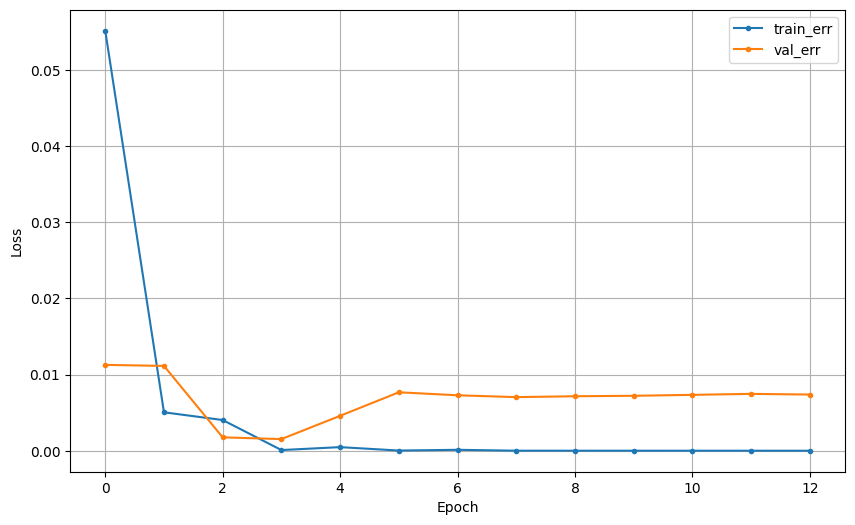

In [ ]:
# 학습곡선
dl_history_plot(hist)

In [ ]:
# 예측 및 평가
y_pred = model1.predict(X_val)
y_pred =np.argmax(y_pred, axis=1)
print(classification_report(y_val, y_pred))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       657
           1       1.00      1.00      1.00       520

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



#### 2) 모델2

In [ ]:
# 모델 설계

In [ ]:
# 컴파일 및 학습

In [ ]:
# 학습곡선

In [ ]:
# 예측 및 평가

### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
# (tip) 정적 행동(0)인 데이터 추출
stop_X = X.loc[y.values == 0, :]
stop_y = train.loc[y.values == 0, 'Activity']

In [ ]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑
le = LabelEncoder()
stop_y = le.fit_transform(stop_y)
X_train, X_val, y_train, y_val = train_test_split(stop_X, stop_y, test_size=0.2, random_state=42)

In [ ]:
# 모델 설계
clear_session()
stop_model = Sequential([
    Input(shape = (n_features, )),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
])
stop_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        35,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,811 (151.61 KB)

 Trainable params: 38,811 (151.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
stop_model.compile(optimizer=Adam(learning_rate=0.01), loss = 'sparse_categorical_crossentropy')
hist = stop_model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0, callbacks=[es]).history

Epoch 29: early stopping


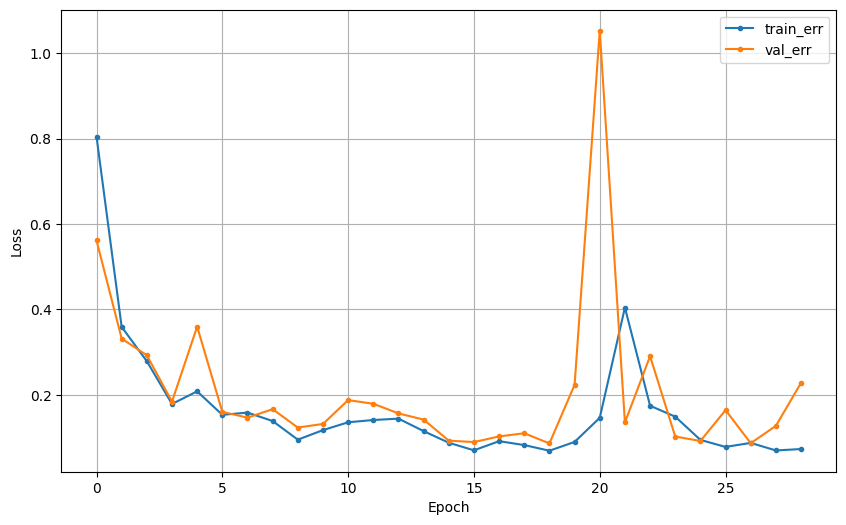

In [ ]:
# 학습곡선
dl_history_plot(hist)

In [ ]:
# 예측 및 평가
y_pred = stop_model.predict(X_val)
y_pred =np.argmax(y_pred, axis=1)
print(classification_report(y_val, y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       221
           1       0.96      0.80      0.88       205
           2       0.84      0.97      0.90       221

    accuracy                           0.93       647
   macro avg       0.94      0.93      0.93       647
weighted avg       0.94      0.93      0.93       647



#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
# (tip) 정적 행동(0)인 데이터 추출
dynamic_X = X.loc[y.values == 1, :]
dynamic_y = train.loc[y.values == 1, 'Activity']

In [ ]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑
le = LabelEncoder()
dynamic_y = le.fit_transform(dynamic_y)
X_train, X_val, y_train, y_val = train_test_split(dynamic_X, dynamic_y, test_size=0.2, random_state=42)

In [ ]:
# 모델 설계
clear_session()
dynamic_model = Sequential([
    Input(shape = (n_features, )),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
])
dynamic_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        35,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,403 (161.73 KB)

 Trainable params: 41,403 (161.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
dynamic_model.compile(optimizer=Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy')
hist = dynamic_model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0, callbacks=[es]).history

Epoch 21: early stopping


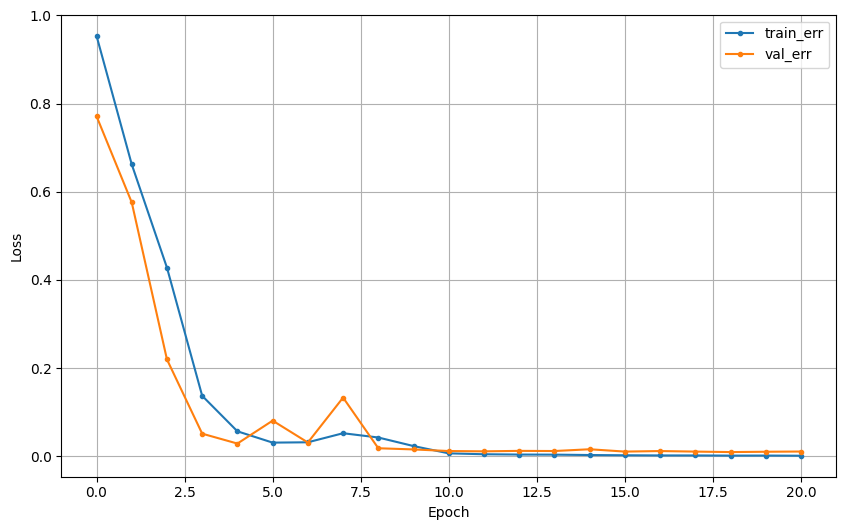

In [ ]:
# 학습곡선
dl_history_plot(hist)

In [ ]:
# 예측 및 평가
y_pred = dynamic_model.predict(X_val)
y_pred =np.argmax(y_pred, axis=1)
print(classification_report(y_val, y_pred))

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       196
           1       0.99      0.99      0.99       163
           2       0.98      0.99      0.98       171

    accuracy                           0.99       530
   macro avg       0.99      0.99      0.99       530
weighted avg       0.99      0.99      0.99       530



### (3) (옵션) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
def smartphone_pipeline(train, test, stage1, stop_model, dynamic_model):
    es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1)
    # 1. 전처리
    # 1-1. 스케일링
    # 1-2. 입력값 만들기
    #-------------------
    train['is_dynamic'] = train.loc[:, 'Activity'].map(lambda x: 0 if x in ['LAYING', 'STANDING', 'SITTING'] else 1)
    test['is_dynamic'] = test.loc[:, 'Activity'].map(lambda x: 0 if x in ['LAYING', 'STANDING', 'SITTING'] else 1)
    X_train = train.drop(['is_dynamic', 'Activity'], axis=1)
    X_test = test.drop(['is_dynamic', 'Activity'], axis=1)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # 2. 예측하기
    # 2-1. 단계1을 모델로 0,1 구분
    # 2-2. 단계 1의 결과로 데이터 나누기
    # 2-3. 단계2 모델로 예측
    # 2-4. 예측 결과 원래 값으로 변환
    # 2-5. 하나로 합쳐보기
    #-------------------
    # 모델학습1
    y_train = train.loc[:, 'is_dynamic']
    y_test = test.loc[:, 'Activity']

    clear_session()
    stage1.compile(optimizer=Adam(learning_rate=0.01), loss = 'sparse_categorical_crossentropy')
    stage1.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0, callbacks=[es])

    stop_inx = (train['is_dynamic'] == 0).values
    X_train_stop = X_train[stop_inx]
    y_train_stop = train.loc[stop_inx, 'Activity']

    dynamic_inx = (train['is_dynamic'] == 1).values
    X_train_dynamic = X_train[dynamic_inx]
    y_train_dynamic = train.loc[dynamic_inx, 'Activity']

    stop_le = LabelEncoder()
    dyn_le  = LabelEncoder()
    y_train_stop = stop_le.fit_transform(y_train_stop)
    y_train_dynamic = dyn_le.fit_transform(y_train_dynamic)
    y_train_stop = pd.Series(y_train_stop)
    y_train_dynamic = pd.Series(y_train_dynamic)

    # 모델 학습2
    stop_model.compile(optimizer=Adam(learning_rate=0.01), loss = 'sparse_categorical_crossentropy')
    stop_model.fit(X_train_stop, y_train_stop, epochs=100, validation_split=0.2, verbose=0, callbacks=[es])
    dynamic_model.compile(optimizer=Adam(learning_rate=0.01), loss = 'sparse_categorical_crossentropy')
    dynamic_model.fit(X_train_dynamic, y_train_dynamic, epochs=100, validation_split=0.2, verbose=0, callbacks=[es])

    # 모델 예측1
    y_pred = stage1.predict(X_test)
    y_pred = y_pred.argmax(axis=1)
    y_pred_full = np.empty(test.shape[0], dtype=object)

    # 모델예측 2-1
    idx_stop = np.where(y_pred == 0)[0]
    y_pred_stop = stop_model.predict(X_test[idx_stop])
    y_pred_stop = y_pred_stop.argmax(axis=1)
    y_pred_full[idx_stop] = stop_le.inverse_transform(y_pred_stop)

    # 모델예측 2-2
    idx_dynamic = np.where(y_pred == 1)[0]
    y_pred_dynamic = dynamic_model.predict(X_test[idx_dynamic])
    y_pred_dynamic = y_pred_dynamic.argmax(axis=1)
    y_pred_full[idx_dynamic] = dyn_le.inverse_transform(y_pred_dynamic)

    y_pred = y_pred_full.astype(str)


    # 3. 최종 성능평가  하기
    return confusion_matrix(y_test, y_pred), classification_report(y_test, y_pred)


In [ ]:
# (옵션) 위 참고해서 분류모델 파이프라인 만들어보기

#### 2) test 셋으로 예측하고 평가하기

In [ ]:
# test 셋의 구조 한번 확인해보고 성능평가 해보기

In [ ]:
print(test.shape)
print(train.shape)

(1471, 562)
(5881, 563)


In [ ]:
cm, cr = smartphone_pipeline(train=train, test=test, stage1=model1, stop_model=stop_model, dynamic_model=dynamic_model)
print(cm)
print(cr)

Epoch 12: early stopping
Epoch 13: early stopping
Epoch 21: early stopping
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
[[291   1   0   0   0   0]
 [  0 217  37   0   0   0]
 [  0   9 278   0   0   0]
 [  0   0   0 219   0   9]
 [  0   0   0   0 195   0]
 [  0   0   0   1   0 214]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.96      0.85      0.90       254
          STANDING       0.88      0.97      0.92       287
           WALKING       1.00      0.96      0.98       228
WALKING_DOWNSTAIRS       1.00      1.00      1.00       195
  WALKING_UPSTAIRS       0.96      1.00      0.98       215

          accuracy                           0.96      1471
         macro avg       0.97      0.96      0.96      1471
      weighted avg       0.96      0.96      0.96      1471

